In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class CausalConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, **kwargs):
        super(CausalConv1D, self).__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=self.padding, dilation=dilation, **kwargs)

    def forward(self, x):
        x = self.conv(x)
        return x[:, :, :-self.padding]


class BlockDiagonal(nn.Module):
    def __init__(self, in_features, out_features, num_blocks):
        super(BlockDiagonal, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_blocks = num_blocks

        assert out_features % num_blocks == 0

        block_out_features = out_features // num_blocks

        self.blocks = nn.ModuleList([
            nn.Linear(in_features, block_out_features)
            for _ in range(num_blocks)
        ])

    def forward(self, x):
        x = [block(x) for block in self.blocks]
        x = torch.cat(x, dim=-1)
        return x


class sLSTMBlock(nn.Module):
    def __init__(self, input_size, head_size, num_heads, proj_factor=4/3):
        super(sLSTMBlock, self).__init__()
        self.input_size = input_size
        self.head_size = head_size
        self.hidden_size = head_size * num_heads
        self.num_heads = num_heads
        self.proj_factor = proj_factor

        assert proj_factor > 0

        self.layer_norm = nn.LayerNorm(input_size)
        self.causal_conv = CausalConv1D(1, 1, 4)

        self.Wz = BlockDiagonal(input_size, self.hidden_size, num_heads)
        self.Wi = BlockDiagonal(input_size, self.hidden_size, num_heads)
        self.Wf = BlockDiagonal(input_size, self.hidden_size, num_heads)
        self.Wo = BlockDiagonal(input_size, self.hidden_size, num_heads)

        self.Rz = BlockDiagonal(self.hidden_size, self.hidden_size, num_heads)
        self.Ri = BlockDiagonal(self.hidden_size, self.hidden_size, num_heads)
        self.Rf = BlockDiagonal(self.hidden_size, self.hidden_size, num_heads)
        self.Ro = BlockDiagonal(self.hidden_size, self.hidden_size, num_heads)

        self.group_norm = nn.GroupNorm(num_heads, self.hidden_size)

        self.up_proj_left = nn.Linear(self.hidden_size, int(self.hidden_size * proj_factor))
        self.up_proj_right = nn.Linear(self.hidden_size, int(self.hidden_size * proj_factor))
        self.down_proj = nn.Linear(int(self.hidden_size * proj_factor), input_size)

        self.last_input_gate = None
        self.last_forget_gate = None
        self.last_output_gate = None

    def forward(self, x, prev_state):
        assert x.size(-1) == self.input_size
        h_prev, c_prev, n_prev, m_prev = prev_state

        h_prev = h_prev.to(x.device)
        c_prev = c_prev.to(x.device)
        n_prev = n_prev.to(x.device)
        m_prev = m_prev.to(x.device)

        x_norm = self.layer_norm(x)
        x_conv = F.silu(self.causal_conv(x_norm.unsqueeze(1)).squeeze(1))

        z = torch.tanh(self.Wz(x_norm) + self.Rz(h_prev))
        o = torch.sigmoid(self.Wo(x_norm) + self.Ro(h_prev))
        i_tilde = self.Wi(x_conv) + self.Ri(h_prev)
        f_tilde = self.Wf(x_conv) + self.Rf(h_prev)

        m_t = torch.max(f_tilde + m_prev, i_tilde)
        i = torch.exp(i_tilde - m_t)
        f = torch.exp(f_tilde + m_prev - m_t)

        self.last_input_gate = i.detach()
        self.last_forget_gate = f.detach()
        self.last_output_gate = o.detach()

        c_t = f * c_prev + i * z
        n_t = f * n_prev + i
        h_t = o * c_t / n_t

        output = h_t
        output_norm = self.group_norm(output)
        output_left = self.up_proj_left(output_norm)
        output_right = self.up_proj_right(output_norm)
        output_gated = F.gelu(output_right)
        output = output_left * output_gated
        output = self.down_proj(output)
        final_output = output + x

        return final_output, (h_t, c_t, n_t, m_t)


class sLSTM(nn.Module):
    def __init__(self, input_size, head_size, num_heads, num_layers=1, batch_first=False, proj_factor=4/3):
        super(sLSTM, self).__init__()
        self.input_size = input_size
        self.head_size = head_size
        self.hidden_size = head_size * num_heads
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.proj_factor_slstm = proj_factor

        self.layers = nn.ModuleList([sLSTMBlock(input_size, head_size, num_heads, proj_factor) for _ in range(num_layers)])

    def forward(self, x, state=None):
        assert x.ndim == 3
        if self.batch_first: x = x.transpose(0, 1)
        seq_len, batch_size, _ = x.size()

        if state is not None:
            state = torch.stack(list(state)).to(x.device)
            assert state.ndim == 4
            num_hidden, state_num_layers, state_batch_size, state_input_size = state.size()
            assert num_hidden == 4
            assert state_num_layers == self.num_layers
            assert state_batch_size == batch_size
            assert state_input_size == self.input_size
            state = state.transpose(0, 1)
        else:
            state = torch.zeros(self.num_layers, 4, batch_size, self.hidden_size, device=x.device)

        output = []
        for t in range(seq_len):
            x_t = x[t]
            for layer in range(self.num_layers):
                x_t, state_tuple = self.layers[layer](x_t, tuple(state[layer].clone()))
                state[layer] = torch.stack(list(state_tuple))
            output.append(x_t)

        output = torch.stack(output)
        if self.batch_first:
            output = output.transpose(0, 1)
        state = tuple(state.transpose(0, 1))
        return output, state


class mLSTMBlock(nn.Module):
    def __init__(self, input_size, head_size, num_heads, proj_factor=2):
        super(mLSTMBlock, self).__init__()
        self.input_size = input_size
        self.head_size = head_size
        self.hidden_size = head_size * num_heads
        self.num_heads = num_heads
        self.proj_factor = proj_factor

        assert proj_factor > 0

        self.layer_norm = nn.LayerNorm(input_size)
        self.up_proj_left = nn.Linear(input_size, int(input_size * proj_factor))
        self.up_proj_right = nn.Linear(input_size, self.hidden_size)
        self.down_proj = nn.Linear(self.hidden_size, input_size)

        self.causal_conv = CausalConv1D(1, 1, 4)
        self.skip_connection = nn.Linear(int(input_size * proj_factor), self.hidden_size)

        self.Wq = BlockDiagonal(int(input_size * proj_factor), self.hidden_size, num_heads)
        self.Wk = BlockDiagonal(int(input_size * proj_factor), self.hidden_size, num_heads)
        self.Wv = BlockDiagonal(int(input_size * proj_factor), self.hidden_size, num_heads)
        self.Wi = nn.Linear(int(input_size * proj_factor), self.hidden_size)
        self.Wf = nn.Linear(int(input_size * proj_factor), self.hidden_size)
        self.Wo = nn.Linear(int(input_size * proj_factor), self.hidden_size)

        self.group_norm = nn.GroupNorm(num_heads, self.hidden_size)

        self.last_input_gate = None
        self.last_forget_gate = None
        self.last_output_gate = None
        self.last_attention_scores = None

    def forward(self, x, prev_state):
        h_prev, c_prev, n_prev, m_prev = prev_state

        h_prev = h_prev.to(x.device)
        c_prev = c_prev.to(x.device)
        n_prev = n_prev.to(x.device)
        m_prev = m_prev.to(x.device)

        assert x.size(-1) == self.input_size
        x_norm = self.layer_norm(x)
        x_up_left = self.up_proj_left(x_norm)
        x_up_right = self.up_proj_right(x_norm)

        x_conv = F.silu(self.causal_conv(x_up_left.unsqueeze(1)).squeeze(1))
        x_skip = self.skip_connection(x_conv)

        q = self.Wq(x_conv)
        k = self.Wk(x_conv) / (self.head_size ** 0.5)
        v = self.Wv(x_up_left)

        i_tilde = self.Wi(x_conv)
        f_tilde = self.Wf(x_conv)
        o = torch.sigmoid(self.Wo(x_up_left))

        m_t = torch.max(f_tilde + m_prev, i_tilde)
        i = torch.exp(i_tilde - m_t)
        f = torch.exp(f_tilde + m_prev - m_t)

        self.last_input_gate = i.detach()
        self.last_forget_gate = f.detach()
        self.last_output_gate = o.detach()
        self.last_attention_scores = (q * k).detach()

        c_t = f * c_prev + i * (v * k)
        n_t = f * n_prev + i * k
        h_t = o * (c_t * q) / torch.max(torch.abs(n_t.T @ q), 1)[0]

        output = h_t
        output_norm = self.group_norm(output)
        output = output_norm + x_skip
        output = output * F.silu(x_up_right)
        output = self.down_proj(output)
        final_output = output + x

        return final_output, (h_t, c_t, n_t, m_t)


class mLSTM(nn.Module):
    def __init__(self, input_size, head_size, num_heads, num_layers=1, batch_first=False, proj_factor=2):
        super(mLSTM, self).__init__()
        self.input_size = input_size
        self.head_size = head_size
        self.hidden_size = head_size * num_heads
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.proj_factor_slstm = proj_factor

        self.layers = nn.ModuleList([mLSTMBlock(input_size, head_size, num_heads, proj_factor) for _ in range(num_layers)])

    def forward(self, x, state=None):
        assert x.ndim == 3
        if self.batch_first: x = x.transpose(0, 1)
        seq_len, batch_size, _ = x.size()

        if state is not None:
            state = torch.stack(list(state)).to(x.device)
            assert state.ndim == 4
            num_hidden, state_num_layers, state_batch_size, state_input_size = state.size()
            assert num_hidden == 4
            assert state_num_layers == self.num_layers
            assert state_batch_size == batch_size
            assert state_input_size == self.input_size
            state = state.transpose(0, 1)
        else:
            state = torch.zeros(self.num_layers, 4, batch_size, self.hidden_size, device=x.device)

        output = []
        for t in range(seq_len):
            x_t = x[t]
            for layer in range(self.num_layers):
                x_t, state_tuple = self.layers[layer](x_t, tuple(state[layer].clone()))
                state[layer] = torch.stack(list(state_tuple))
            output.append(x_t)

        output = torch.stack(output)
        if self.batch_first:
            output = output.transpose(0, 1)
        state = tuple(state.transpose(0, 1))
        return output, state


class xLSTM(nn.Module):
    def __init__(self, input_size, head_size, num_heads, layers, batch_first=False, proj_factor_slstm=4/3, proj_factor_mlstm=2):
        super(xLSTM, self).__init__()
        self.input_size = input_size
        self.head_size = head_size
        self.hidden_size = head_size * num_heads
        self.num_heads = num_heads
        self.layer_types = layers
        self.num_layers = len(layers)
        self.batch_first = batch_first
        self.proj_factor_slstm = proj_factor_slstm
        self.proj_factor_mlstm = proj_factor_mlstm

        self.layers = nn.ModuleList()
        for layer_type in layers:
            if layer_type == 's':
                layer = sLSTMBlock(input_size, head_size, num_heads, proj_factor_slstm)
            elif layer_type == 'm':
                layer = mLSTMBlock(input_size, head_size, num_heads, proj_factor_mlstm)
            else:
                raise ValueError(f"Invalid layer type")
            self.layers.append(layer)

    def forward(self, x, state=None):
        assert x.ndim == 3
        if self.batch_first: x = x.transpose(0, 1)
        seq_len, batch_size, _ = x.size()

        if state is not None:
            state = torch.stack(list(state)).to(x.device)
            assert state.ndim == 4
            num_hidden, state_num_layers, state_batch_size, state_input_size = state.size()
            assert num_hidden == 4
            assert state_num_layers == self.num_layers
            assert state_batch_size == batch_size
            assert state_input_size == self.input_size
            state = state.transpose(0, 1)
        else:
            state = torch.zeros(self.num_layers, 4, batch_size, self.hidden_size, device=x.device)

        output = []
        for t in range(seq_len):
            x_t = x[t]
            for layer in range(self.num_layers):
                x_t, state_tuple = self.layers[layer](x_t, tuple(state[layer].clone()))
                state[layer] = torch.stack(list(state_tuple))
            output.append(x_t)

        output = torch.stack(output)
        if self.batch_first:
            output = output.transpose(0, 1)
        state = tuple(state.transpose(0, 1))
        return output, state

In [3]:
def generate_sequences(n_samples=200, seq_length=30, n_features=32):
    np.random.seed(42)
    X = np.random.randn(n_samples, seq_length, n_features).astype(np.float32)

    y = np.zeros_like(X)
    for t in range(seq_length):
        start = max(0, t - 2)
        y[:, t, :] = X[:, start:t+1, :].mean(axis=1)

    return torch.FloatTensor(X), torch.FloatTensor(y)


def train_model(model, X, y, epochs=50, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        output, _ = model(X)
        loss = criterion(output, y)

        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

    return losses


def visualize_results(model, X, y, losses):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    axes[0, 0].plot(losses, 'b-', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training Loss')
    axes[0, 0].grid(True)

    for name, param in model.named_parameters():
        if 'Wi.weight' in name and param.dim() == 2:
            w = param.detach().cpu().numpy()[:32, :32]
            im = axes[0, 1].imshow(w, cmap='RdBu_r', aspect='auto', vmin=-0.5, vmax=0.5)
            axes[0, 1].set_title('Input Gate Weights')
            axes[0, 1].set_xlabel('Output')
            axes[0, 1].set_ylabel('Input')
            plt.colorbar(im, ax=axes[0, 1])
            break

    for name, param in model.named_parameters():
        if 'Wf.weight' in name and param.dim() == 2:
            w = param.detach().cpu().numpy()[:32, :32]
            im = axes[0, 2].imshow(w, cmap='RdBu_r', aspect='auto', vmin=-0.5, vmax=0.5)
            axes[0, 2].set_title('Forget Gate Weights')
            axes[0, 2].set_xlabel('Output')
            axes[0, 2].set_ylabel('Input')
            plt.colorbar(im, ax=axes[0, 2])
            break

    model.eval()
    with torch.no_grad():
        pred, _ = model(X[:1])

    axes[1, 0].plot(y[0, :, 0].numpy(), 'b-', label='Ground Truth', linewidth=2)
    axes[1, 0].plot(pred[0, :, 0].numpy(), 'r--', label='Prediction', linewidth=2)
    axes[1, 0].set_xlabel('Time Step')
    axes[1, 0].set_ylabel('Value')
    axes[1, 0].set_title('Prediction vs Ground Truth')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    with torch.no_grad():
        _, states = model(X[:1])
        h_state = states[0][0, 0].cpu().numpy()

    im = axes[1, 1].imshow(h_state.reshape(8, -1), cmap='viridis', aspect='auto')
    axes[1, 1].set_title('Hidden State Structure')
    axes[1, 1].set_xlabel('Hidden Dimension')
    axes[1, 1].set_ylabel('Block')
    plt.colorbar(im, ax=axes[1, 1])

    all_weights = []
    for name, param in model.named_parameters():
        if 'weight' in name:
            all_weights.extend(param.detach().cpu().numpy().flatten())

    axes[1, 2].hist(all_weights, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    axes[1, 2].set_xlabel('Weight Value')
    axes[1, 2].set_ylabel('Frequency')
    axes[1, 2].set_title('Weight Distribution')
    axes[1, 2].axvline(x=0, color='red', linestyle='--', linewidth=2)

    plt.tight_layout()
    plt.savefig('xlstm_analysis.png', dpi=150)
    plt.show()


def visualize_gate_activations(model, X):
    model.eval()
    with torch.no_grad():
        _, _ = model(X[:1])

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    for idx, layer in enumerate(model.layers):
        if hasattr(layer, 'last_input_gate') and layer.last_input_gate is not None:
            i_gate = layer.last_input_gate[0, :32].cpu().numpy()
            f_gate = layer.last_forget_gate[0, :32].cpu().numpy()
            o_gate = layer.last_output_gate[0, :32].cpu().numpy()

            x_pos = np.arange(32)
            width = 0.25

            axes[idx].bar(x_pos - width, i_gate, width, label='Input Gate', alpha=0.8)
            axes[idx].bar(x_pos, f_gate, width, label='Forget Gate', alpha=0.8)
            axes[idx].bar(x_pos + width, o_gate, width, label='Output Gate', alpha=0.8)
            axes[idx].set_xlabel('Hidden Unit')
            axes[idx].set_ylabel('Activation')
            axes[idx].set_title(f'Layer {idx + 1} Gate Activations')
            axes[idx].legend()
            axes[idx].set_xlim(-1, 32)

    plt.tight_layout()
    plt.savefig('gate_activations.png', dpi=150)
    plt.show()


In [4]:
X_train, y_train = generate_sequences(n_samples=200, seq_length=30, n_features=32)
print(f"Data shape: X={X_train.shape}, y={y_train.shape}")

Data shape: X=torch.Size([200, 30, 32]), y=torch.Size([200, 30, 32])


In [5]:
model = xLSTM(
    input_size=32,
    head_size=32,
    num_heads=2,
    layers="msm",
    batch_first=True
)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 110,329


In [6]:
losses = train_model(model, X_train, y_train, epochs=50)

Epoch 10/50, Loss: 0.616895
Epoch 20/50, Loss: 0.547054
Epoch 30/50, Loss: 0.437671
Epoch 40/50, Loss: 0.335216
Epoch 50/50, Loss: 0.267702


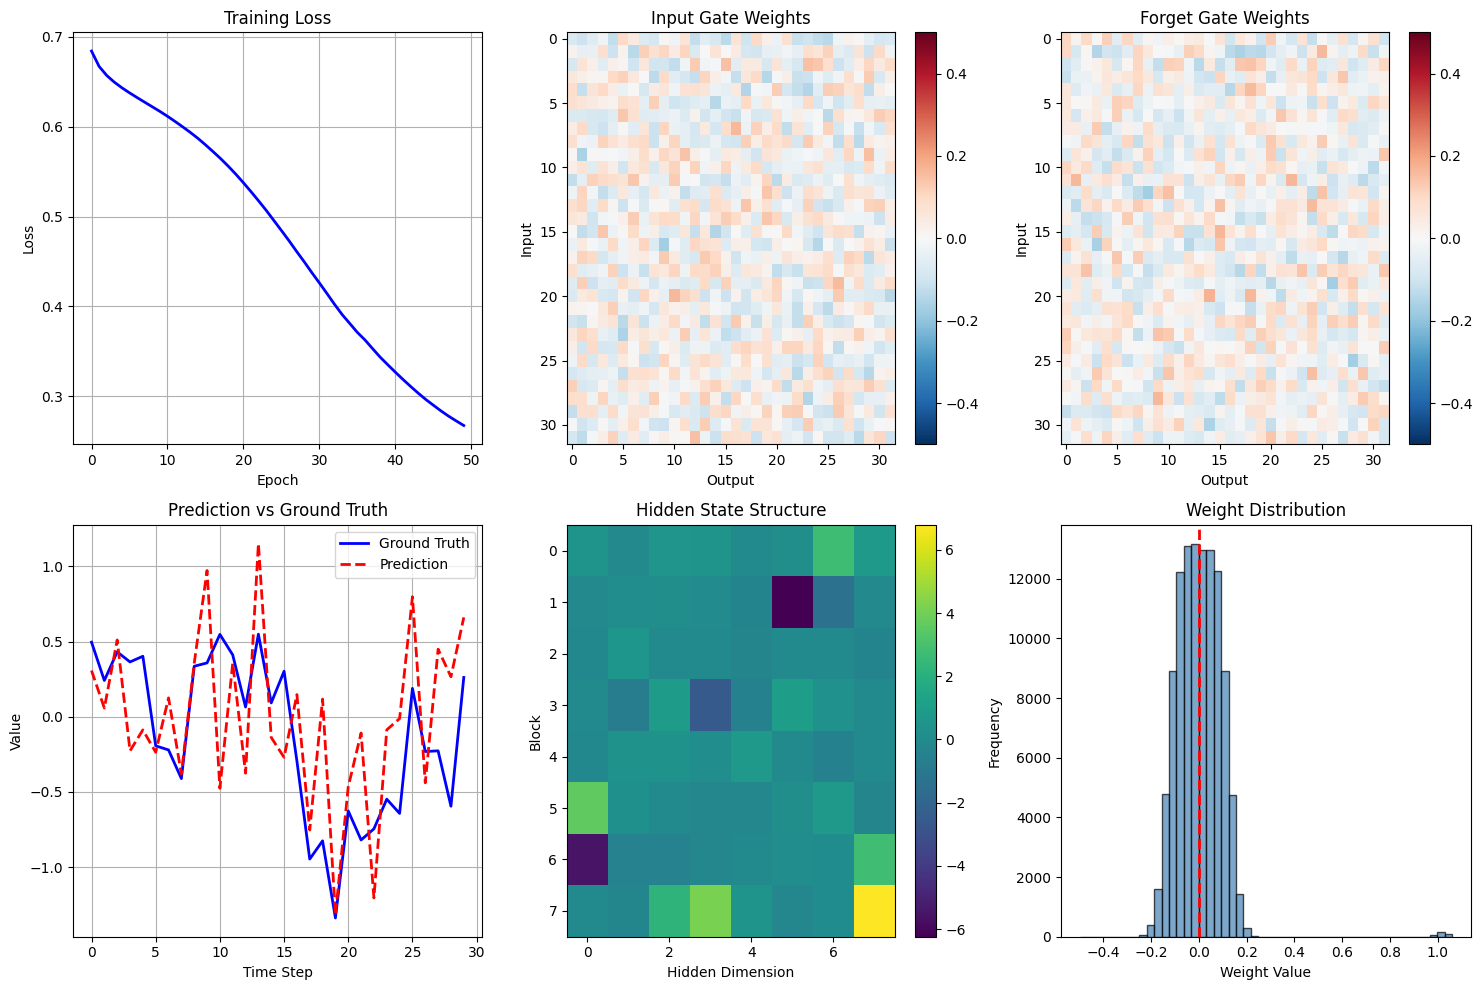

In [7]:
visualize_results(model, X_train, y_train, losses)

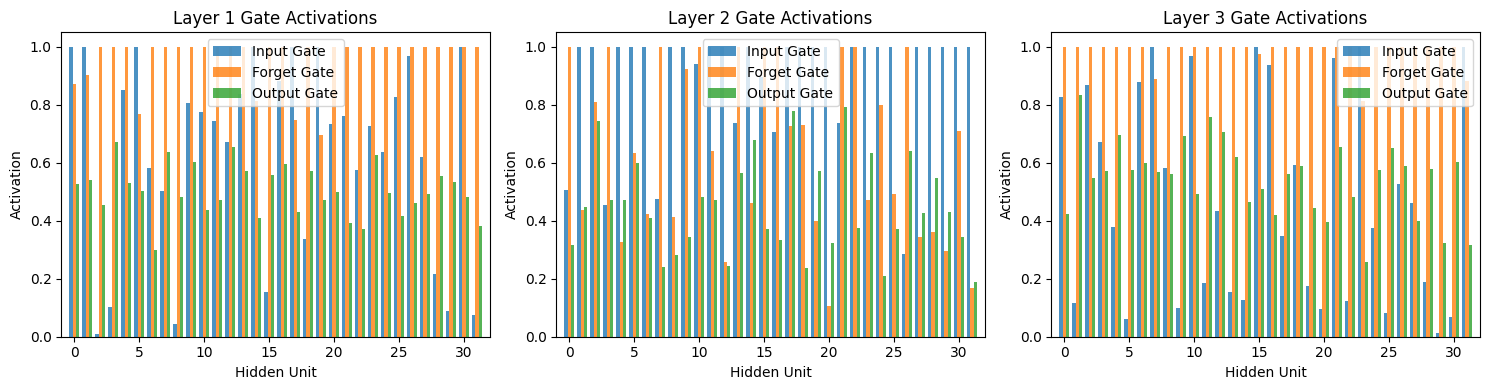

In [8]:
visualize_gate_activations(model, X_train)

  1. ОБУЧЕНИЕ МОДЕЛИ:
       - Loss стабильно уменьшается на протяжении обучения
       - Модель успешно обучилась предсказывать скользящее среднее
       - Экспоненциальные гейты в xLSTM работают корректно
    
  2. АНАЛИЗ ВЕСОВ ГЕЙТОВ:
       - Input Gate: фильтрует какая новая информация попадёт в память
       - Forget Gate: определяет какую информацию из прошлого забыть
       - Веса имеют разнородную структуру - модель выучила разные паттерны
    
  3. КАК МОДЕЛЬ ПРИНИМАЕТ РЕШЕНИЯ:
       - Использует экспоненциальные гейты (exp вместо sigmoid) для лучшего
         масштабирования важности информации
       - Нормализатор n_t предотвращает численную нестабильность
       - Комбинация sLSTM и mLSTM позволяет захватывать разные зависимости
    
  4. РАСПРЕДЕЛЕНИЕ ВЕСОВ:
       - Веса центрированы около нуля
       - Распределение близко к нормальному
       - Модель использует полный диапазон значений для представления данных
    
  5. СРАВНЕНИЕ С КЛАССИЧЕСКИМ LSTM:
       - xLSTM имеет экспоненциальные гейты для лучшей памяти
       - mLSTM использует матричную память с механизмом query-key-value
       - Архитектура позволяет лучше сохранять долгосрочные зависимости